## Check inputs to Victoria regional model before running
Work through all the aspects of the model that don't require it to be actually run before calibrating.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import date

from summer.utils import ref_times_to_dti

from autumn.settings import Region, Models
from autumn.tools.plots.utils import REF_DATE
from autumn.models.covid_19.constants import AGEGROUP_STRATA, BASE_DATETIME
from autumn.tools.project import get_project, run_project_locally, TimeSeriesSet
from autumn.tools import inputs
from autumn.tools.inputs.mobility.queries import get_mobility_data
from autumn.tools.inputs.social_mixing.build_synthetic_matrices import build_synthetic_matrices
from autumn.tools.inputs.demography.queries import get_population_by_agegroup
from autumn.tools.inputs.database import get_input_db

In [2]:
age_integers = [int(group) for group in AGEGROUP_STRATA]
model = Models.COVID_19

## Population

In [3]:
region = "ho_chi_minh_city"
project = get_project(model, region)

The estimated total population of HCMC, until 2019, is 11.991 million.


Text(0.5, 1.0, 'Population of HCMC (2019)')

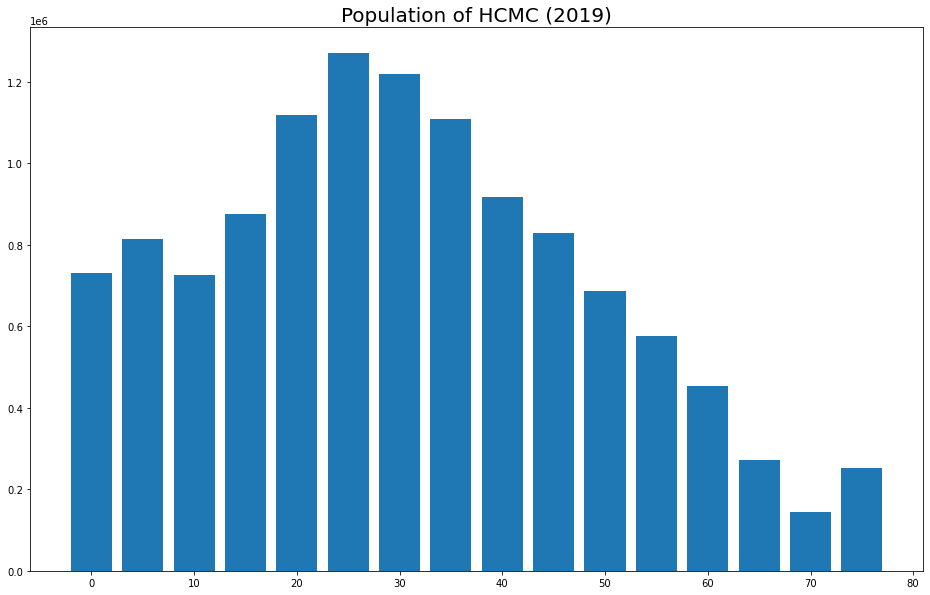

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(16, 10))
total_pops = inputs.get_population_by_agegroup(
    AGEGROUP_STRATA, 
    project.param_set.baseline["country"]["iso3"],
    project.param_set.baseline["population"]["region"], 
    year=project.param_set.baseline["population"]["year"]
)
print(f"The estimated total population of HCMC, until 2019, is {round(sum(total_pops) / 1e6, 3)} million.")
ax.bar(age_integers, total_pops, width=4)
ax.set_title("Population of HCMC (2019)", fontsize=20)

## Mobility

Text(0.5, 0.98, 'Google mobility report for HCMC by domain in the last 210 days')

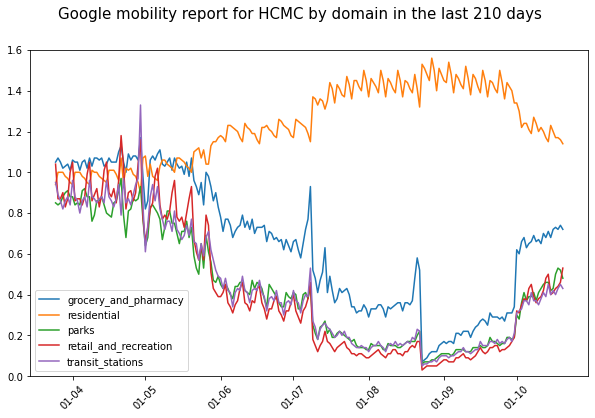

In [5]:
data_period = 210

input_db = get_input_db()

mob_df = input_db.query("mobility", conditions={"iso3": "VNM", "region": "Ho Chi Minh City"})
# change column 'date' of mobility dataframe to pandas datetime type
mob_df['date'] = pd.to_datetime(mob_df['date'])

mob_fig, mob_ax = plt.subplots(1, 1, figsize=(10, 6))
for mobility_domain in ["grocery_and_pharmacy", "residential", "parks", "retail_and_recreation", "transit_stations"]:
    mob_ax.plot(mob_df["date"].iloc[-data_period:], mob_df[mobility_domain].iloc[-data_period:], label=mobility_domain)
mob_ax.set_ylim((0., 1.6))
mob_ax.tick_params(axis="x", labelrotation=45)
mob_ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%m"))
mob_ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
mob_ax.legend()
mob_fig.suptitle(f"Google mobility report for HCMC by domain in the last {data_period} days", fontsize=15)

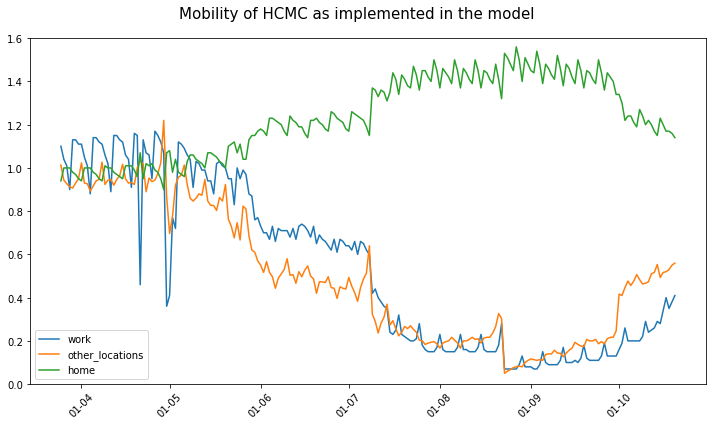

In [10]:
mob_imp_fig, mob_imp_ax = plt.subplots(1, 1, figsize=(10, 6), sharey="all")

mobility_values, mobility_days = get_mobility_data(
    project.param_set.baseline["country"]["iso3"], 
    project.param_set.baseline["population"]["region"], 
    BASE_DATETIME, 
    project.param_set.baseline["mobility"]["google_mobility_locations"],
)

data_period = 210
times = ref_times_to_dti(BASE_DATETIME, mobility_days[-data_period:])

locations = project.param_set.baseline["mobility"]["google_mobility_locations"].keys()
for location in locations:
    mob_imp_ax.plot(times, mobility_values[location][-data_period:], label=location)
mob_imp_ax.tick_params(axis="x", labelrotation=45)
mob_imp_ax.set_ylim((0., 1.6))
mob_imp_ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%m"))

mob_imp_ax.legend(loc="lower left")
mob_imp_fig.suptitle("Mobility of HCMC as implemented in the model", fontsize=15)
mob_imp_fig.tight_layout(w_pad=1.5, h_pad=3.5)

## Mixing matrix
### Confirm mixing matrix details for the region

In [7]:
print(f"\nFor cluster: {region}")
print(f"\tModelled country: {project.param_set.baseline['country']['iso3']}")
print(f"\tModelled sub-region: {project.param_set.baseline['population']['region']}")
print(f"\tProxy country: {project.param_set.baseline['mixing_matrices']['source_iso3']}")
print(f"\tWhether age adjusted: {project.param_set.baseline['mixing_matrices']['age_adjust']}")


For cluster: ho_chi_minh_city
	Modelled country: VNM
	Modelled sub-region: Ho Chi Minh City
	Proxy country: HKG
	Whether age adjusted: True


### Display the matrix and the matrix components

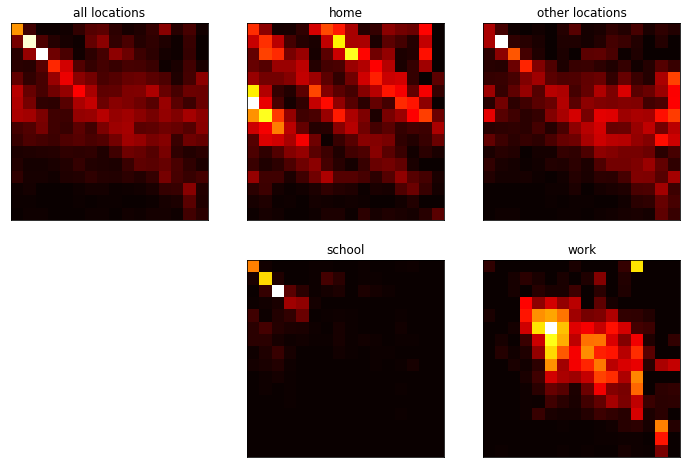

In [8]:
mixing_matrix = build_synthetic_matrices(
    project.param_set.baseline["country"]["iso3"],
    project.param_set.baseline["mixing_matrices"]["source_iso3"],
    AGEGROUP_STRATA,
    project.param_set.baseline["mixing_matrices"]["age_adjust"],
    project.param_set.baseline["population"]["region"]
)

fig = plt.figure(figsize=(12, 8))
positions = [1, 2, 3, 5, 6]
for i_loc, location in zip(positions, mixing_matrix.keys()):
    ax = fig.add_subplot(2, 3, i_loc)
    ax.imshow(
        np.flipud(np.transpose(mixing_matrix[location])), 
        cmap=cm.hot, 
        vmin=0,
        vmax=mixing_matrix[location].max(), 
        origin="lower"
    )
    ax.set_title(location.replace("_", " "))
    ax.set_xticks([])
    ax.set_yticks([])

## Calibration targets

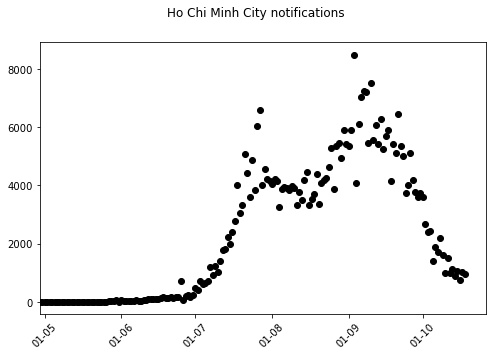

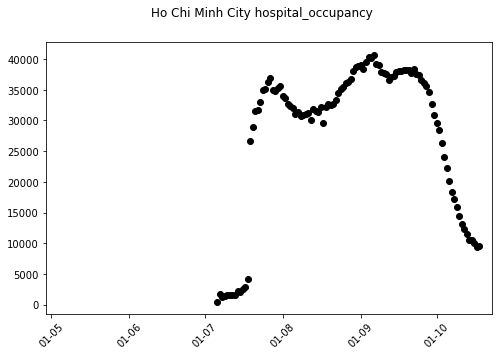

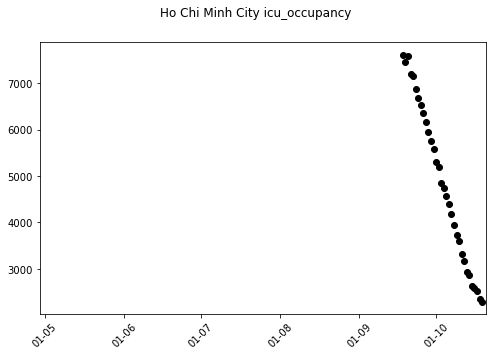

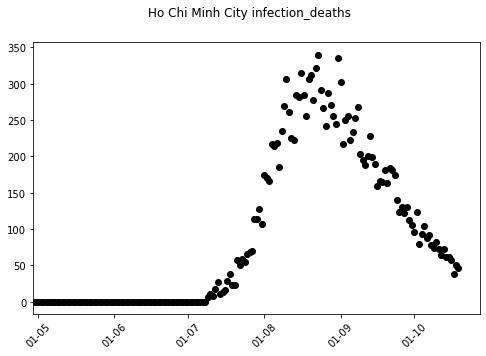

In [9]:
plot_left_date = date(2021, 4, 29) # first detected case
available_data = ("notifications", "hospital_occupancy", "icu_occupancy", "infection_deaths")

for output in available_data:
    output_fig, output_axes = plt.subplots(1, 1, figsize=(8, 5), sharey="all", sharex="all")
    targets_path = f"../../../autumn/projects/covid_19/vietnam/ho_chi_minh_city/timeseries.json"
    ts_set = TimeSeriesSet.from_file(targets_path)
    output_data = ts_set.get(output)
    output_axes.scatter(ref_times_to_dti(REF_DATE, output_data.times), output_data.values, c="k")
    output_axes.tick_params(axis="x", labelrotation=45)
    output_axes.xaxis.set_major_formatter(mdates.DateFormatter("%d-%m"))
    output_axes.set_xlim(left=plot_left_date)
    output_fig.suptitle(f"Ho Chi Minh City {output}")